In [1]:
%matplotlib inline

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd

import nibabel as nib
from mvpa2.suite import *
from sklearn.linear_model import RidgeCV, Ridge
from joblib.parallel import Parallel, delayed
from scipy.spatial.distance import cdist, squareform

/opt/conda/envs/neuro27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
epi_fn = '/idata/DBIC/castello/thesis/outputs/preproc/sub-sid000005/sub-sid000005_ses-hyperface1_task-visualmemory_run-02_bold_space-T1w_preproc_ds_tp.nii.gz'
mask_fn = '/idata/DBIC/castello/thesis/outputs/unionmask/sub-sid000005/sub-sid000005_space-T1w_unionbrainmask.nii.gz'
ds = fmri_dataset(epi_fn, mask=mask_fn)

 * Please note: warnings are printed only once, but underlying problem might occur many times *


In [3]:
events_fn = '/idata/DBIC/castello/thesis/inputs/data/sub-sid000005/ses-hyperface1/func/sub-sid000005_ses-hyperface1_task-visualmemory_run-02_events.tsv'

In [135]:
def prepare_dataset(epi_fn, mask_fn, events_fn):
    ds = fmri_dataset(epi_fn, mask=mask_fn)
    ds.sa['chunks'] = [1]
    zscore(ds)
    
    events = pd.read_csv(events_fn, sep='\t')
    events['onset_tr'] = np.round(events.onset, 0).astype(int)
    mask_clips = map(lambda x: 'mp4' in x and not x.startswith('catch'), 
                     events.trial_type)
    clip_onset = events[mask_clips].onset_tr.tolist()
    start, end = clip_onset[0], clip_onset[-1] + 14  # 4s clip + 10s fixation
    ds = ds[start:end]
    
    # save also clip info
    events = events[mask_clips]
    clips = [''] * ds.nsamples
    for idx, row in events.iterrows():
        clips[row.onset_tr - start] = row.trial_type
    
    cl = clips[0]
    for ic in range(1, len(clips)):
        if not clips[ic]:
            clips[ic] = cl
        else:
            cl = clips[ic]
    ds.sa['clip'] = clips
    return ds

In [136]:
# load stim labels
stimlbl = pd.read_csv('/idata/DBIC/castello/thesis/inputs/stim_labels.tsv', sep='\t', index_col=0)

In [137]:
stimlbl_dummy = pd.get_dummies(stimlbl)

In [138]:
stimlbl_dummy.head()

,gender_Female,gender_Male,age_0-10,age_11-20,age_21-30,age_31-40,age_41-50,age_51-60,age_61-70,age_70+,...,emotion_Happiness,emotion_Neutral,emotion_Sadness,emotion_Surprise,npeople_1,npeople_2,npeople_more than 2,headdir_Mostly Center,headdir_Mostly Left,headdir_Mostly Right
clip,,,,,,,,,,,,,,,,,,,,,
1U9n2Z68-A0_000028.mp4,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1U9n2Z68-A0_000049.mp4,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1U9n2Z68-A0_000110.mp4,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1U9n2Z68-A0_000130.mp4,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1U9n2Z68-A0_000140.mp4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1


In [139]:
def build_matpred(ds, stimlbl_dummy):
    mat = [stimlbl_dummy.loc[lbl].tolist() for lbl in ds.sa.clip]
    # the last 10 TRs are fixation, so impose 0
    mat = np.vstack(mat)
    mat[-10:] = 0.
    return mat

In [140]:
epi_fns = sorted(glob('/idata/DBIC/castello/thesis/outputs/preproc/sub-sid000005/sub-sid000005_ses-hyperface*_task-visualmemory_run-*_bold_space-T1w_preproc_ds_tp.nii.gz'))
event_fns = sorted(glob('/idata/DBIC/castello/thesis/inputs/data/sub-sid000005/ses-hyperface*/func/sub-sid000005_ses-hyperface*_task-visualmemory_run-*_events.tsv'))

In [141]:
def load_data(epi, event, i_run):
    ds = prepare_dataset(epi, mask_fn, event)
    ds.sa['run'] = [i_run]
    mat = build_matpred(ds, stimlbl_dummy)
    return ds, mat

In [142]:
out_data = Parallel(n_jobs=12)(
    delayed(load_data)(epi, event, i_run) 
    for i_run, (epi, event) in enumerate(zip(epi_fns, event_fns), 1))

In [143]:
dss, mat = zip(*out_data)
dss = vstack(dss, a=0)
mats = np.vstack(mat)

In [15]:
# dss = []
# mats = []
# for i, (epi, event) in enumerate(zip(epi_fns, event_fns), 1):
#     print("{}".format(i))
#     ds = prepare_dataset(epi, mask_fn, event)
#     ds.sa['run'] = [i]
#     dss.append(ds)
#     mats.append(build_matpred(ds, stimlbl_dummy))

# dss = vstack(dss)
# mats = np.vstack(mats)

In [144]:
def delay_mat(mat, delays, tr=1):
    trs, nfeatures = mat.shape
    ndelays = len(delays)
    mat_delay = np.zeros((trs, nfeatures*(ndelays + 1)))
    mat_delay[:, :nfeatures] = mat
    
    for i, delay in enumerate(delays, 2):
        start = delay * tr
        mat_delay[start:, (i-1)*nfeatures:i*nfeatures] = mat[:trs-start]
    return mat_delay

In [149]:
delays = [4, 6, 8]
mats_d = delay_mat(mats, delays)

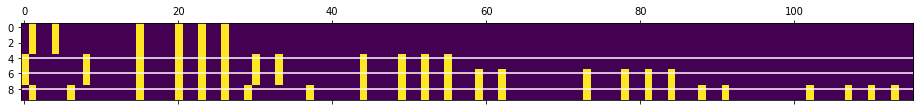

In [152]:
plt.matshow(mats_d[:10])
for delay in delays:
    plt.axhline(delay, color='white')

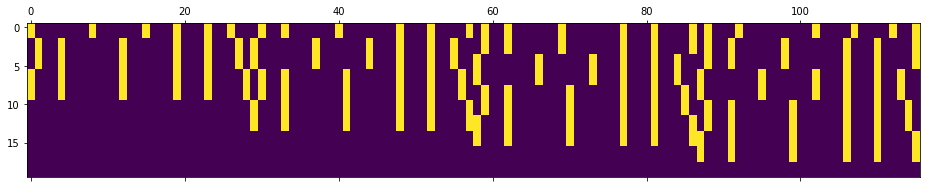

In [160]:
plt.matshow(mats_d[-20:])

In [23]:
def _run_block_traintest(mat, ds, alphas=np.logspace(1, 4, 20)):
    """This function runs ridge regression CV for one block and returns the error curves"""
    # run ridge regression for each voxel
    ridge = RidgeCV(alphas=alphas, fit_intercept=False, store_cv_values=True)
    nfeatures = ds.shape[1]
    
    ridge.fit(mat, ds)
    return ridge.cv_values_.mean(axis=0)

In [24]:
def _run_block_traintest_bestalpha(mat_trte, ds_trte, mat_valid, ds_valid, best_alpha):
    """This function runs ridge regression with the best alpha and returns the weights and the score"""
    ridge = Ridge(alpha=best_alpha, fit_intercept=False)
    ridge.fit(mat_trte, ds_trte)
    pred = ridge.predict(mat_valid)
    score = 1. - np.diag(cdist(pred.T, ds_valid.T, metric='correlation'))
    return ridge.coef_, score

In [20]:
alphas = np.logspace(1, 4, 20)

In [27]:
def run_one_validation(validation_run, njobs=40):
    # split validation from training/testing
    idx_valid = np.where(dss.sa.run == validation_run)[0]
    idx_trte = np.where(dss.sa.run != validation_run)[0]
    assert len(set(idx_valid).intersection(idx_trte)) == 0
    
    ds_valid = dss[idx_valid]
    mat_valid = mats_d[idx_valid]
    ds_trte = dss[idx_trte]
    mat_trte = mats_d[idx_trte]
    
    # divide into blocks for parallel processing
    nvoxels = ds_trte.nfeatures
    blocks = np.array_split(np.arange(nvoxels), njobs)
    
    # 1. compute optimal alpha across all voxels
    print("Validation run {0:02d}: computing best alpha across all voxels".format(validation_run))
    out = Parallel(n_jobs=njobs)(
        delayed(_run_block_traintest)
        (mat_trte, ds_trte.samples[:, idx]) for idx in blocks)
    out = np.vstack(out)
    
    best_alpha = alphas[np.argmin(out.mean(axis=0))]
    print("Validation run {0:02d}: found best alpha {1}".format(validation_run, best_alpha))
    
    # 2. use best_alpha to get score on validation test
    out_ba = Parallel(n_jobs=njobs)(
        delayed(_run_block_traintest_bestalpha)
        (mat_trte, ds_trte.samples[:, idx], 
         mat_valid, ds_valid.samples[:, idx], 
         best_alpha) for idx in blocks)
    
    weights, score = zip(*out_ba)
    weights = np.vstack(weights)
    score = np.nan_to_num(np.hstack(score))
    return weights, score

In [28]:
res_vrun = []
for vrun in range(1, 13):
    res_vrun.append(run_one_validation(vrun))

Validation run 01: computing best alpha across all voxels
Validation run 01: found best alpha 784.759970351
Validation run 02: computing best alpha across all voxels
Validation run 02: found best alpha 784.759970351
Validation run 03: computing best alpha across all voxels
Validation run 03: found best alpha 784.759970351
Validation run 04: computing best alpha across all voxels
Validation run 04: found best alpha 784.759970351
Validation run 05: computing best alpha across all voxels
Validation run 05: found best alpha 784.759970351
Validation run 06: computing best alpha across all voxels
Validation run 06: found best alpha 784.759970351
Validation run 07: computing best alpha across all voxels
Validation run 07: found best alpha 784.759970351
Validation run 08: computing best alpha across all voxels
Validation run 08: found best alpha 784.759970351
Validation run 09: computing best alpha across all voxels
Validation run 09: found best alpha 784.759970351
Validation run 10: computing

In [38]:
weights, score = zip(*res_vrun)
weights = np.dstack(weights)
score = np.vstack(score)

In [32]:
score_avg = np.mean(score, axis=0)

In [41]:
np.savez('/idata/DBIC/castello/thesis/outputs/encoding/sub-sid000005/vrun_all.npz',
        weights=weights, score=score)

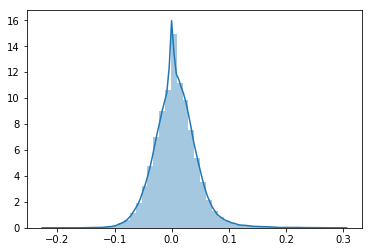

In [40]:
sns.distplot(score_avg)

In [44]:
score_map = map2nifti(
    Dataset(score_avg[None, :], fa=dss.fa, a=dss.a))

In [45]:
score_map.to_filename('/idata/DBIC/castello/thesis/outputs/encoding/sub-sid000005/avgscores_new.nii.gz')

## Let's check the weights

In [3]:
res = np.load('/idata/DBIC/castello/thesis/outputs/encoding/sub-sid000005/vrun_all.npz')

In [4]:
weights = res['weights']
score = res['score']

In [8]:
nfeatures = stimlbl_dummy.shape[1]
nvoxels = weights.shape[0]

In [9]:
# avg across folds
weights_avg = weights.mean(axis=-1)
# avg across lags
weights_avg = weights.reshape((nvoxels, nfeatures, -1)).mean(axis=-1)

In [10]:
feature_names = stimlbl_dummy.columns

In [11]:
weights_avg.shape

(117609, 29)

In [56]:
# let's just save individual weights for now
for i, name in enumerate(feature_names):
    tmp = map2nifti(Dataset(weights_avg[:, i][None, :], fa=dss.fa, a=dss.a))
    tmp.to_filename('/idata/DBIC/castello/thesis/outputs/encoding/sub-sid000005/weights_{}.nii.gz'.format(name))

In [12]:
feature_names

Index([u'gender_Female', u'gender_Male', u'age_0-10', u'age_11-20',
       u'age_21-30', u'age_31-40', u'age_41-50', u'age_51-60', u'age_61-70',
       u'age_70+', u'ethnicity_Asian', u'ethnicity_Black or African American',
       u'ethnicity_Hispanic or Latino', u'ethnicity_Indian',
       u'ethnicity_Other', u'ethnicity_White', u'emotion_Anger',
       u'emotion_Disgust', u'emotion_Fear', u'emotion_Happiness',
       u'emotion_Neutral', u'emotion_Sadness', u'emotion_Surprise',
       u'npeople_1', u'npeople_2', u'npeople_more than 2',
       u'headdir_Mostly Center', u'headdir_Mostly Left',
       u'headdir_Mostly Right'],
      dtype='object')

In [17]:
# for each voxel, let's binarize the max weight, and add an arbitrary threshold
thr = np.percentile(weights_avg[:, :2].flatten(), 95)
amax = np.argmax(weights_avg[:, :2], axis=1)
max_weight = np.array([w[a] for w, a in zip(weights_avg[:, :2], amax)])
gender = (amax + 1) * (max_weight >= thr)

In [21]:
epi_fn = '/idata/DBIC/castello/thesis/outputs/preproc/sub-sid000005/sub-sid000005_ses-hyperface1_task-visualmemory_run-02_bold_space-T1w_preproc_ds_tp.nii.gz'
mask_fn = '/idata/DBIC/castello/thesis/outputs/unionmask/sub-sid000005/sub-sid000005_space-T1w_unionbrainmask.nii.gz'
ds = fmri_dataset(epi_fn, mask=mask_fn)

 * Please note: warnings are printed only once, but underlying problem might occur many times *


In [25]:
m = map2nifti(Dataset(gender[None, :], fa=ds.fa, a=ds.a))

In [26]:
m.to_filename('/idata/DBIC/castello/thesis/outputs/encoding/sub-sid000005/genderweights.nii.gz')

## Another test -- let's take the max weight for each voxel across features

In [29]:
feature_cat = map(lambda x: x.split('_')[0], feature_names)

In [40]:
unq_feature_cat = list(set(feature_cat))
map_feature_cat = {f: i for i, f in enumerate(unq_feature_cat, 1)}

In [35]:
max_weight = np.argmax(weights_avg, axis=1)

In [43]:
bin_max_weight = np.array([map_feature_cat[feature_cat[v]] for v in max_weight])

In [123]:
m = map2nifti(Dataset(bin_max_weight[None, :], fa=ds.fa, a=ds.a))
m.to_filename('/idata/DBIC/castello/thesis/outputs/encoding/sub-sid000005/max_weights_cat.nii.gz')

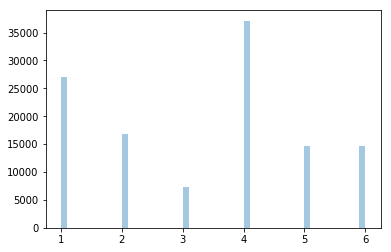

In [46]:
sns.distplot(bin_max_weight, kde=False)

In [124]:
unq_feature_cat

['emotion', 'npeople', 'gender', 'age', 'headdir', 'ethnicity']

## Significance

1. Bootstrap
2. Get SD and compute z-value
3. Compute p-value based on t-distribution
4. FDR correct

In [110]:
rng = np.random.RandomState(42)

In [73]:
# convert to fisher z-scored
score_z = np.arctanh(score)

In [111]:
nbootstraps = 10000
idxs = rng.choice(np.arange(12), size=(nbootstraps, 12), )

In [112]:
# compute z-values using bootstrapped SD
bs_sample = np.array([score_z[idx].mean(axis=0) for idx in idxs])
bs_sample_std = bs_sample.std(axis=0)

score_z_avg = score_z.mean(axis=0)
score_z_t = np.nan_to_num(score_z_avg/bs_sample_std)

In [115]:
# compute p-vals and do FDR correction them
from scipy import stats
pval = stats.distributions.t.sf(score_z_t, 11)

from mne.stats import fdr_correction
h, pval_c = fdr_correction(pval)

In [118]:
m = map2nifti(Dataset(-np.log10(pval_c)[None, :], fa=ds.fa, a=ds.a))
m.to_filename('/idata/DBIC/castello/thesis/outputs/encoding/sub-sid000005/pval_corrected.nii.gz')

In [125]:
-np.log10(0.05)

1.3010299956639813

In [120]:
score_z_t.min()

-10.617711247780651

In [121]:
score_z_avg[0]

0.029885868628745624

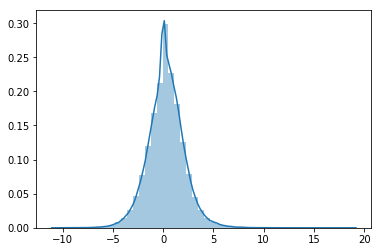

In [163]:
sns.distplot(score_z_t)

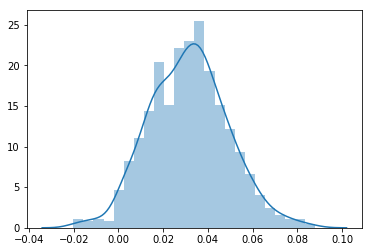

In [81]:
sns.distplot(bs_sample[:, 0])

In [71]:
bs_sample.shape

(100, 117609)

In [65]:
score[:, idx].shape

(12, 12)

In [63]:
sns.dis

(100, 12)

In [51]:
unq_feature_cat

['emotion', 'npeople', 'gender', 'age', 'headdir', 'ethnicity']

In [50]:
feature_cat

['gender',
 'gender',
 'age',
 'age',
 'age',
 'age',
 'age',
 'age',
 'age',
 'age',
 'ethnicity',
 'ethnicity',
 'ethnicity',
 'ethnicity',
 'ethnicity',
 'ethnicity',
 'emotion',
 'emotion',
 'emotion',
 'emotion',
 'emotion',
 'emotion',
 'emotion',
 'npeople',
 'npeople',
 'npeople',
 'headdir',
 'headdir',
 'headdir']

In [49]:
unq_feature_cat[3]

'age'

In [27]:
weights_avg.shape

(117609, 29)

- Step 1: find alpha across all voxels. Divide into train/test, run across all voxels, then average the error curves across voxels
- Step 2: once found, fit it again with that alpha, and then predict on the validation

In [215]:
# def _run_block_traintest(mat, ds):
#     # run ridge regression for each voxel
#     alphas = np.logspace(1, 3, 20)
#     ridge = RidgeCV(alphas=alphas, fit_intercept=False, store_cv_values=True)
#     nfeatures = ds.shape[1]
    
#     alphas_cv = []
#     for i in range(nfeatures):
#         ridge.fit(mat, ds[:, i])
#         alphas_cv.append(ridge.cv_values_.mean(axis=0)[:, None])
#     return np.hstack(alphas_cv)

In [217]:
nvoxels = ds_trte.nfeatures
nblocks = 40
blocks = np.array_split(np.arange(nvoxels), nblocks)

In [218]:
out = Parallel(n_jobs=nblocks)(
    delayed(_run_block_traintest)
    (mat_trte, ds_trte.samples[:, idx]) for idx in blocks)
out = np.vstack(out)

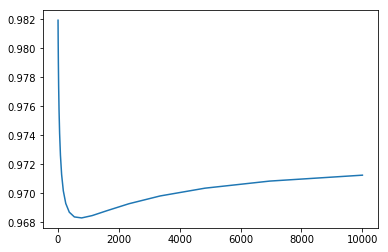

In [219]:
alphas = np.logspace(1, 4, 20)
plt.plot(alphas, out.mean(axis=0));

In [220]:
best_alpha = alphas[np.argmin(out.mean(axis=0))]
print(best_alpha)

784.759970351


In [222]:
out_ba = Parallel(n_jobs=nblocks)(
    delayed(_run_block_traintest_bestalpha)
    (mat_trte, ds_trte.samples[:, idx], 
     mat_valid, ds_valid.samples[:, idx], 
     best_alpha) for idx in blocks)

In [223]:
weights, score = zip(*out_ba)

In [224]:
weights = np.vstack(weights)
score = np.nan_to_num(np.hstack(score))

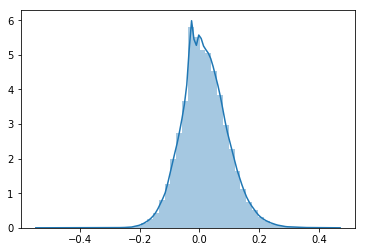

In [225]:
sns.distplot(score)

In [164]:
dss.nsamples

2960

In [168]:
np.sum(dss.sa.run != 1)

2713